In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [42]:
# Standard library
import os
import random
from glob import glob

# Data & computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Computer vision
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Utilities
from tqdm import tqdm

In [43]:
# Configuration
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
dataset_path = "/kaggle/input/skin-cancer-the-ham10000-dataset/"

In [44]:
import os
import pandas as pd

# List all files in the download path
print("Files in dataset:")
for root, dirs, files in os.walk(path):
    for file in files[:10]:  # Show first 10 files
        print(os.path.join(root, file))
    if files:
        print(f"... (total {len(files)} files in {root})")

Files in dataset:
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
... (total 5 files in /kaggle/input/skin-cancer-mnist-ham10000)
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM1000

In [45]:
# Correct way: use forward slashes
metadata = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
num_examples = len(metadata)
print(f"✅ Dataset loaded: {num_examples} samples")


✅ Dataset loaded: 10015 samples


In [46]:
# Check missing values
print("\n🔍 Missing values:")
missing_percent = (metadata.isnull().sum() / len(metadata) * 100).round(2)
for col, percent in missing_percent.items():
    print(f"{col}: {percent}%")


🔍 Missing values:
lesion_id: 0.0%
image_id: 0.0%
dx: 0.0%
dx_type: 0.0%
age: 0.57%
sex: 0.0%
localization: 0.0%


In [47]:
import os
from glob import glob

# This is your path (already correct)
dataset_path = "/kaggle/input/skin-cancer-mnist-ham10000"   # or whatever kagglehub gave you

# Collect from ALL four possible folders (uppercase + lowercase)
folders = [
    'HAM10000_images_part_1',
    'HAM10000_images_part_2',
    'ham10000_images_part_1',   # lowercase duplicate
    'ham10000_images_part_2'    # lowercase duplicate
]

image_path = {}

for part in folders:
    folder_path = os.path.join(dataset_path, part)
    if os.path.exists(folder_path):                     # ← important!
        print(f"Scanning {folder_path} ...")
        part_images = {
            os.path.splitext(os.path.basename(x))[0]: x
            for x in glob(os.path.join(folder_path, "*.jpg"))
        }
        image_path.update(part_images)
        print(f"   → Found {len(part_images)} images in this folder")
    else:
        print(f"Skipping {folder_path} (not found)")

print(f"\nTotal unique images found: {len(image_path)}")

Scanning /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1 ...
   → Found 5000 images in this folder
Scanning /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2 ...
   → Found 5015 images in this folder
Scanning /kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1 ...
   → Found 5000 images in this folder
Scanning /kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2 ...
   → Found 5015 images in this folder

Total unique images found: 10015


In [48]:
# Add labels and paths to metadata
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
metadata['path'] = metadata['image_id'].map(image_path.get)

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...


In [49]:
# Step 1: Remove or skip corrupted images from your mapping
valid_image_path = {}
corrupted_count = 0

for img_id, img_path in image_path.items():
    if os.path.getsize(img_path) == 0:
        corrupted_count += 1
        continue
    try:
        # Quick check without loading full image
        with Image.open(img_path) as img:
            img.verify()
        valid_image_path[img_id] = img_path
    except Exception:
        corrupted_count += 1
        continue

print(f"Removed {corrupted_count} corrupted/broken images")
print(f"Healthy images: {len(valid_image_path)} → {(len(valid_image_path)/10015)*100:.2f}%")
image_path = valid_image_path   # ← overwrite the old dict

Removed 0 corrupted/broken images
Healthy images: 10015 → 100.00%


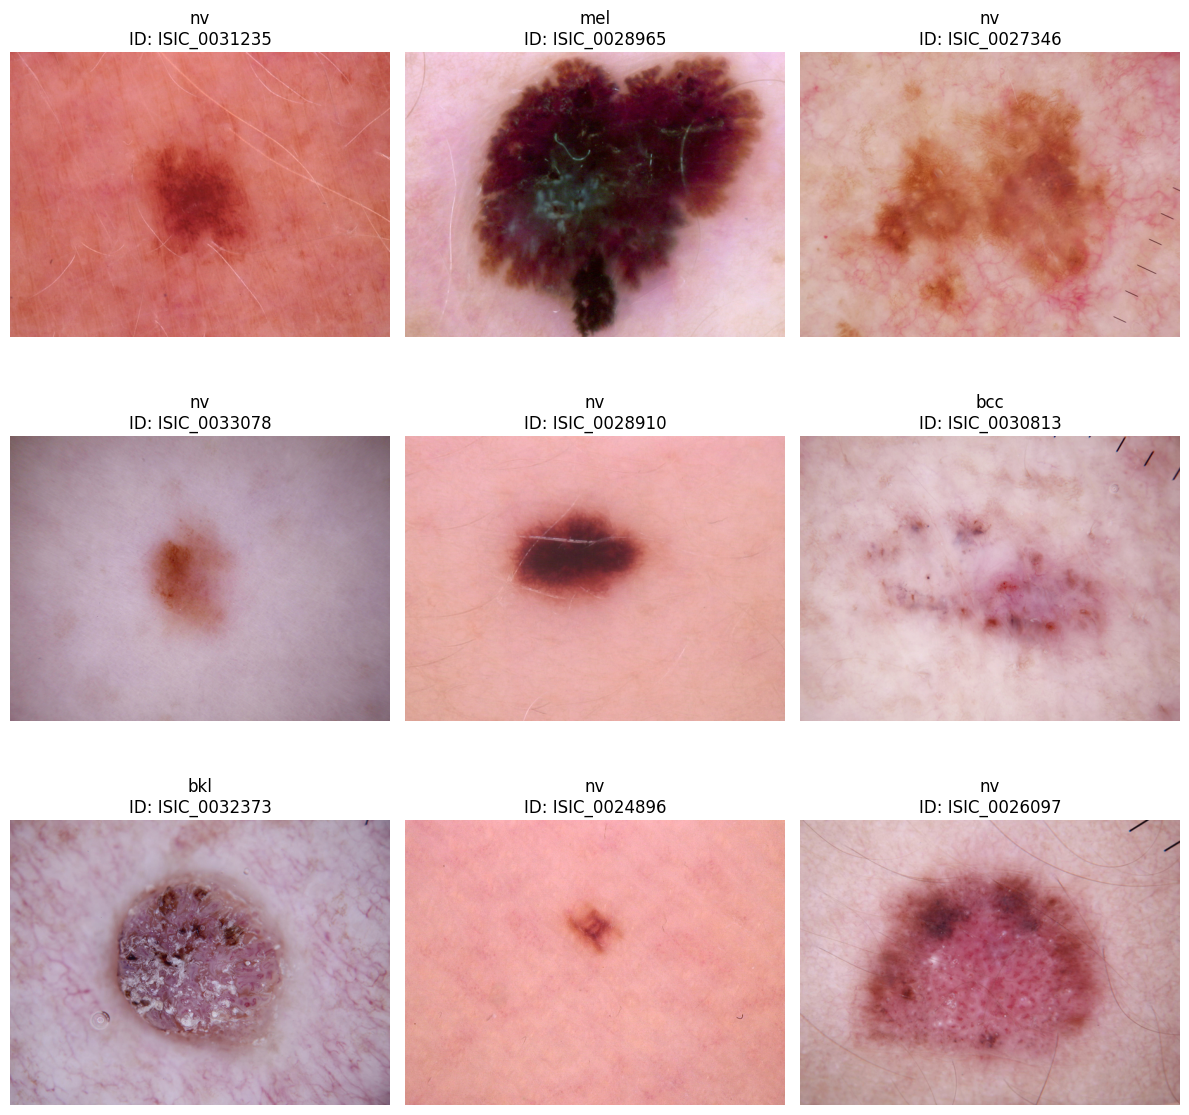

In [50]:
# Show sample images
random_ids = random.sample(list(image_path.keys()), 9)

plt.figure(figsize=(12, 12))
for i, img_id in enumerate(random_ids):
    img_path = image_path[img_id]
    img = Image.open(img_path)

    # Find the label for this image ID
    row = metadata[metadata['image_id'] == img_id]
    label = row['dx'].iloc[0] if not row.empty else 'Unknown'

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f'{label}\nID: {img_id}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [51]:
# Class distribution
print("Imbalanced dataset distribution:")
print(metadata['label'].value_counts().sort_index())

Imbalanced dataset distribution:
label
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
Name: count, dtype: int64


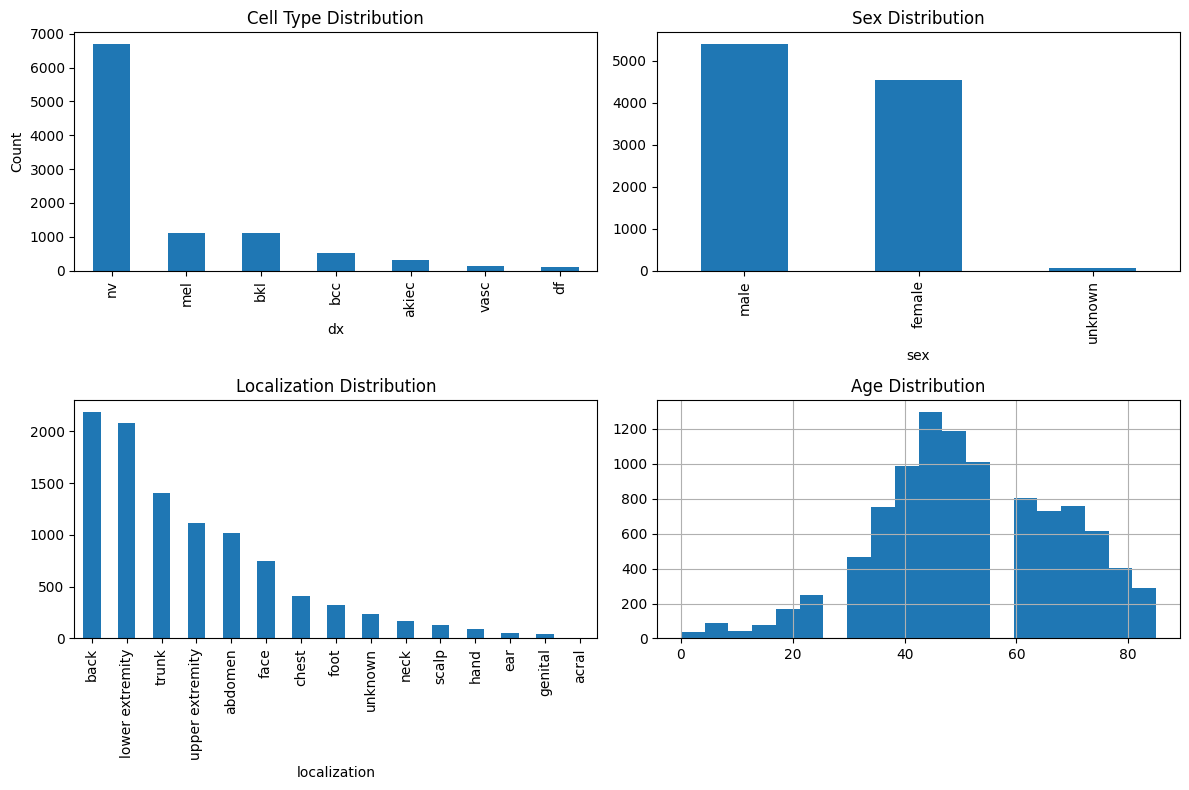

In [52]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metadata['dx'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Cell Type Distribution')
axes[0,0].set_ylabel('Count')

metadata['sex'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Sex Distribution')

metadata['localization'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Localization Distribution')

metadata['age'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')

plt.tight_layout()
plt.show()

In [53]:
# SPLIT FIRST - by unique images to avoid any overlap
train_df, test_df = train_test_split(
    metadata,
    test_size=0.2,
    random_state=42,
    stratify=metadata['label']
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=42,
    stratify=train_df['label']
)

print(f"After splitting:")
print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

After splitting:
Train: 6009 samples
Val: 2003 samples
Test: 2003 samples


In [54]:
# Balance multipliers for each class
data_aug_rate = [15, 10, 5, 50, 5, 1, 40]

def balance_training_data(train_df, data_aug_rate):
    """Balance only the training data by duplicating minority classes"""
    balanced_dfs = []

    for class_idx, rate in enumerate(data_aug_rate):
        class_df = train_df[train_df['label'] == class_idx]
        if len(class_df) > 0 and rate > 0:
            # Multiply the class by the rate
            augmented_df = pd.concat([class_df] * rate, ignore_index=True)
            balanced_dfs.append(augmented_df)

    return pd.concat(balanced_dfs, ignore_index=True)

In [55]:
# Balance only training data
train_df_balanced = balance_training_data(train_df, data_aug_rate)

print(f"\n✅ Balanced training set:")
print(train_df_balanced['label'].value_counts().sort_index())
print(f"Total balanced training samples: {len(train_df_balanced)}")


✅ Balanced training set:
label
0    2955
1    3080
2    3295
3    3450
4    3340
5    4023
6    3400
Name: count, dtype: int64
Total balanced training samples: 23543


In [56]:
# Verify no image overlap between sets
def check_no_image_overlap(train_df, val_df, test_df):
    train_imgs = set(train_df['image_id'].unique())
    val_imgs = set(val_df['image_id'].unique())
    test_imgs = set(test_df['image_id'].unique())

    overlaps = [
        len(train_imgs.intersection(val_imgs)),
        len(train_imgs.intersection(test_imgs)),
        len(val_imgs.intersection(test_imgs))
    ]

    if sum(overlaps) == 0:
        print("✓ No image overlap between sets - clean split!")
    else:
        print(f"⚠ Warning: Image overlaps detected: {overlaps}")

check_no_image_overlap(train_df_balanced, val_df, test_df)

✓ No image overlap between sets - clean split!


In [57]:
# Custom Dataset class
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_paths = dataframe['path'].values
        self.labels = dataframe['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [58]:
# Data transforms
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# train_transform = transforms.Compose([
#     transforms.Resize((input_size, input_size)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(norm_mean, norm_std)
# ])

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),  # Increase rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Add crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),  # Add blur
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [59]:
# Create datasets
train_dataset = SkinDataset(train_df_balanced, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

In [61]:
# Fixed DataLoaders – copy-paste this exactly
torch.backends.cudnn.benchmark = True

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,          # ← must be 0 with the kmader dataset + global dict
    pin_memory=True,
    persistent_workers=False   # ← REMOVE or set False when num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False
)

In [62]:
# # Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# model.fc = nn.Sequential(
#     nn.Dropout(0.1),
#     nn.Linear(model.fc.in_features, 7)
# )
# model = model.to(device)

# Try EfficientNet instead of ResNet50
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, 7)
)
model = model.to(device)

In [63]:
# Setup training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6)

print(f"✅ Model created and moved to {device}")

✅ Model created and moved to cuda


In [64]:

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer,
                num_epochs=30, patience=6):

    print(f"🚀 Training EfficientNet for {num_epochs} epochs (patience: {patience})")
    print("-" * 60)

    # Training history
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            current_loss = train_loss / (progress_bar.n + 1)
            current_acc = (train_correct / train_total) * 100
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc * 100)
        val_accs.append(val_acc * 100)

        print(f'Epoch {epoch+1}: loss: {train_loss_avg:.4f} - accuracy: {train_acc*100:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc*100:.2f}%')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print('✓ Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'⏹️ Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model for final evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'✅ Best model from epoch {best_epoch} loaded')

    # Final test evaluation
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = (test_correct / test_total) * 100
    print(f"\n🎯 Final Test Accuracy: {test_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs, test_acc, all_labels, all_predictions

In [65]:
train_losses, val_losses, train_accs, val_accs, test_accuracy, true_labels, predictions = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=10, patience=6
)

🚀 Training EfficientNet for 10 epochs (patience: 6)
------------------------------------------------------------


Epoch 1/10: 100%|██████████| 184/184 [08:26<00:00,  2.75s/it, loss=1.0745, accuracy=61.18%]


Epoch 1: loss: 1.0745 - accuracy: 61.18% - val_loss: 0.6478 - val_accuracy: 74.89%
✓ Validation loss improved. Best model updated.


Epoch 2/10: 100%|██████████| 184/184 [08:19<00:00,  2.71s/it, loss=0.5012, accuracy=81.49%]


Epoch 2: loss: 0.5012 - accuracy: 81.49% - val_loss: 0.5517 - val_accuracy: 78.43%
✓ Validation loss improved. Best model updated.


Epoch 3/10: 100%|██████████| 184/184 [08:18<00:00,  2.71s/it, loss=0.3567, accuracy=86.60%]


Epoch 3: loss: 0.3567 - accuracy: 86.60% - val_loss: 0.5046 - val_accuracy: 82.18%
✓ Validation loss improved. Best model updated.


Epoch 4/10: 100%|██████████| 184/184 [08:31<00:00,  2.78s/it, loss=0.2605, accuracy=90.47%]


Epoch 4: loss: 0.2605 - accuracy: 90.47% - val_loss: 0.5182 - val_accuracy: 81.03%
No improvement. Patience: 1/6


Epoch 5/10: 100%|██████████| 184/184 [08:17<00:00,  2.71s/it, loss=0.2091, accuracy=92.41%]


Epoch 5: loss: 0.2091 - accuracy: 92.41% - val_loss: 0.5133 - val_accuracy: 81.38%
No improvement. Patience: 2/6


Epoch 6/10: 100%|██████████| 184/184 [08:19<00:00,  2.72s/it, loss=0.1669, accuracy=93.99%]


Epoch 6: loss: 0.1669 - accuracy: 93.99% - val_loss: 0.5006 - val_accuracy: 83.72%
✓ Validation loss improved. Best model updated.


Epoch 7/10: 100%|██████████| 184/184 [08:23<00:00,  2.74s/it, loss=0.1343, accuracy=95.20%]


Epoch 7: loss: 0.1343 - accuracy: 95.20% - val_loss: 0.4915 - val_accuracy: 85.32%
✓ Validation loss improved. Best model updated.


Epoch 8/10: 100%|██████████| 184/184 [08:20<00:00,  2.72s/it, loss=0.1145, accuracy=95.85%]


Epoch 8: loss: 0.1145 - accuracy: 95.85% - val_loss: 0.4839 - val_accuracy: 86.17%
✓ Validation loss improved. Best model updated.


Epoch 9/10: 100%|██████████| 184/184 [08:24<00:00,  2.74s/it, loss=0.0988, accuracy=96.63%]


Epoch 9: loss: 0.0988 - accuracy: 96.63% - val_loss: 0.5384 - val_accuracy: 84.92%
No improvement. Patience: 1/6


Epoch 10/10: 100%|██████████| 184/184 [08:20<00:00,  2.72s/it, loss=0.0906, accuracy=96.79%]


Epoch 10: loss: 0.0906 - accuracy: 96.79% - val_loss: 0.5707 - val_accuracy: 83.28%
No improvement. Patience: 2/6
✅ Best model from epoch 8 loaded

🎯 Final Test Accuracy: 84.82%


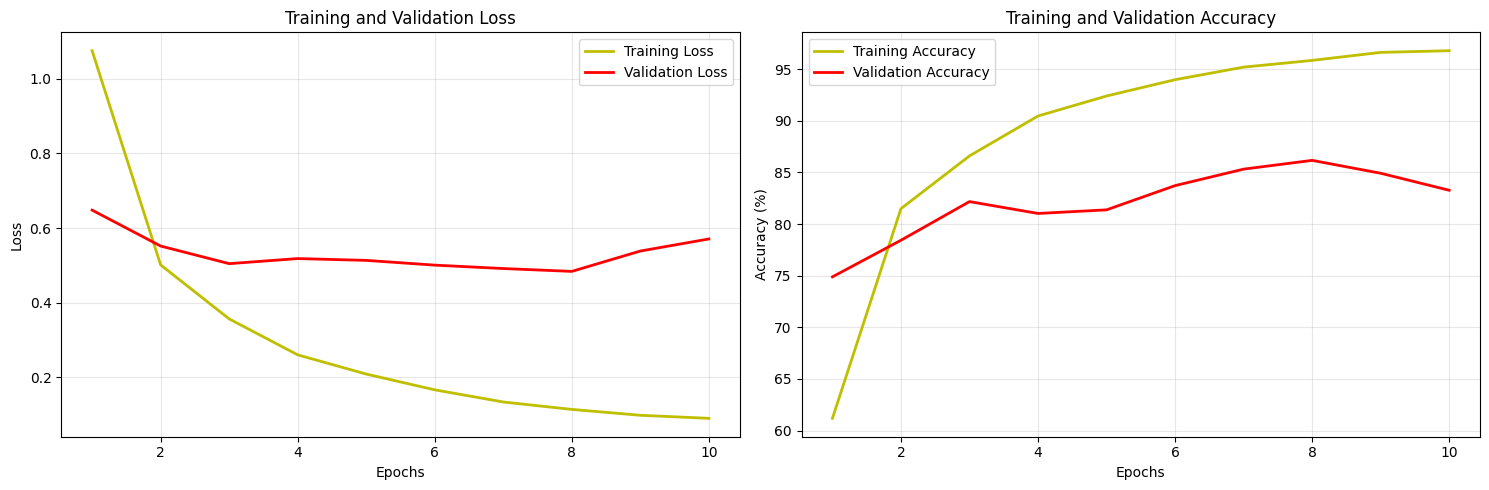

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_range = range(1, len(train_losses) + 1)

ax1.plot(epochs_range, train_losses, 'y-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, train_accs, 'y-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

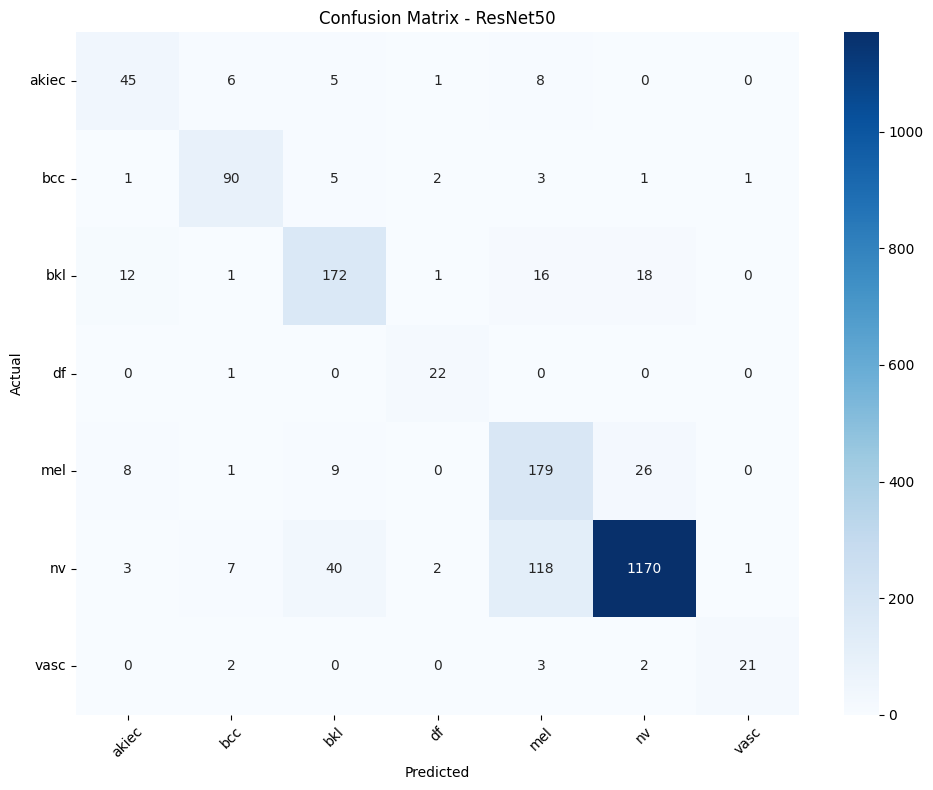

In [67]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix - ResNet50')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [68]:
# Classification Report
print("\n📋 Classification Report:")
print("="*50)
report = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
print(report)
print("="*50)


📋 Classification Report:
              precision    recall  f1-score   support

       akiec       0.65      0.69      0.67        65
         bcc       0.83      0.87      0.85       103
         bkl       0.74      0.78      0.76       220
          df       0.79      0.96      0.86        23
         mel       0.55      0.80      0.65       223
          nv       0.96      0.87      0.91      1341
        vasc       0.91      0.75      0.82        28

    accuracy                           0.85      2003
   macro avg       0.78      0.82      0.79      2003
weighted avg       0.87      0.85      0.86      2003



In [69]:
# Final Summary
print("\n" + "="*60)
print("🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉")
print("="*60)
print(f"✅ Total epochs trained: {len(train_losses)}")
print(f"✅ Best train accuracy: {max(train_accs):.2f}%")
print(f"✅ Best validation accuracy: {max(val_accs):.2f}%")
print(f"✅ Final test accuracy: {test_accuracy:.2f}%")
print("="*60)
print("🔬 Ready for production deployment with clean methodology!")


🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 10
✅ Best train accuracy: 96.79%
✅ Best validation accuracy: 86.17%
✅ Final test accuracy: 84.82%
🔬 Ready for production deployment with clean methodology!


In [70]:
torch.save(model.state_dict(), "HAM10000_EfficientNet_Final.pth")
print("Model saved! Starting download...")
from google.colab import files
files.download("HAM10000_EfficientNet_Final.pth")

Model saved! Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
import torch
from google.colab import files

# 1. Save the model in .h5 format (Keras/TensorFlow style)
model_save_path = "HAM10000_EfficientNet_B0_best.h5"

# EfficientNet from torchvision is a PyTorch model → we need to trace/script it first
# This converts it to TorchScript (fully compatible with .h5 saving via torch.save)
model.eval()                                   # VERY IMPORTANT
example_input = torch.randn(1, 3, 224, 224).cuda()   # or .cpu() if no GPU

# Option A – Recommended: Scripted model (works 100%)
traced_model = torch.jit.trace(model, example_input)

# Option B – If trace fails, use script (rarely needed)
# traced_model = torch.jit.script(model)

# Save as .h5 (this is the standard extension for TorchScript models too)
torch.save(traced_model.state_dict(), model_save_path)   # or torch.jit.save(traced_model, "model.h5")

print(f"Model saved as {model_save_path} ({os.path.getsize(model_save_path)/1e6:.1f} MB)")

# 2. Trigger instant download to your laptop
files.download(model_save_path)

Model saved as HAM10000_EfficientNet_B0_best.h5 (16.4 MB)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save full model (architecture + weights) in Kaggle working directory
torch.save(model, "skin_cancer_model.pth")

<>:142: SyntaxWarning: invalid escape sequence '\S'
<>:142: SyntaxWarning: invalid escape sequence '\S'
E:\Temp\ipykernel_20548\2400355236.py:142: SyntaxWarning: invalid escape sequence '\S'
  "E:\Skin Cancer Detection\Backend\HAM10000 Data\HAM10000_images_part_2\ISIC_0029319.jpg",



🔍 Analysis for: E:\Skin Cancer Detection\Backend\HAM10000 Data\HAM10000_images_part_2\ISIC_0029319.jpg
   akiec: 0.0%
   bcc  : 0.0%
   bkl  : 0.0%
   df   : 0.0%
👉 mel  : 94.1%
   nv   : 5.9%
   vasc : 0.0%


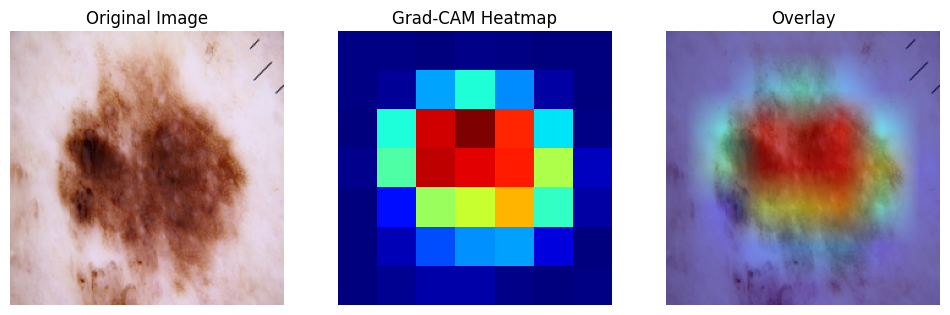


🎯 Top Prediction: mel (Confidence: 94.1%)


In [5]:
# 1. LOAD FULL MODEL (architecture + weights)
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# -----------------------------
# Load the model (saved with torch.save(model, ...))
# -----------------------------
def load_model(model_path=r"E:\Skin Cancer Detection\Saved Model\skin_cancer_model.pth", device="cpu"):
    # Force full model loading (architecture + weights)
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()
    model.to(device)
    return model

# -----------------------------
# Grad-CAM implementation
# -----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        # GAP over H and W
        gradients = self.gradients.mean(dim=[0, 2, 3])
        cam = (gradients[None, :, None, None] * self.activations).sum(dim=1).squeeze()
        cam = torch.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.cpu().numpy()
        return cam

# -----------------------------
# Predict + visualize GradCAM
# -----------------------------
def predict_and_visualize(image_path, model, device="cpu"):
    label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()

    # Print class probabilities
    print(f"\n🔍 Analysis for: {image_path}")
    print("=" * 50)
    for i, (label, prob) in enumerate(zip(label_names, probabilities[0])):
        marker = "👉" if i == predicted_class else "  "
        print(f"{marker} {label:5}: {prob:.1%}")
    print("=" * 50)

    # Grad-CAM
    try:
        target_layer = model.blocks[-1]   # timm EfficientNet
    except AttributeError:
        target_layer = model.features[-1]  # torchvision EfficientNet

    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate(input_tensor, predicted_class)

    # Prepare visualization
    img = np.array(image.resize((224, 224)))

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # ✅ Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Blend heatmap with image
    overlay = np.uint8(0.5 * heatmap + 0.5 * img)

    # Show result
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

    return label_names[predicted_class], probabilities[0][predicted_class].item()

# -----------------------------
# Usage Example
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(r"E:\Skin Cancer Detection\Saved Model\skin_cancer_model.pth", device=device)

prediction, confidence = predict_and_visualize(
    "E:\Skin Cancer Detection\Backend\HAM10000 Data\HAM10000_images_part_2\ISIC_0029319.jpg",
    model,
    device=device
)
print(f"\n🎯 Top Prediction: {prediction} (Confidence: {confidence:.1%})")
